In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
import torch
from tqdm.auto import tqdm
import random
import os

def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [2]:
DATA_PATH = os.getcwd()+'/data/news/'
SEED = 42

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device,DATA_PATH

('cuda', 'c:\\study\\04_NLP/data/news/')

In [3]:
train = pd.read_csv(f"{DATA_PATH}train_news.csv")
test = pd.read_csv(f"{DATA_PATH}test_news.csv")
train.shape, test.shape

((89320, 3), (38280, 2))

In [4]:
import nltk

nltk.download("punkt") # 토큰화 하기 위해 다운로드
nltk.download("stopwords") # 불용어 리스트
nltk.download("averaged_perceptron_tagger") # 품사정보를 추출하기 위해 다운로드

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hopio\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hopio\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hopio\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [5]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [6]:
docs = train["desc"].str.replace(r"[^\w ]+", "", regex=True).str.lower()
docs

0        sudan has decided to postpone a decision to ex...
1        cell phone manufacturers are teaming up to bri...
2        although the united states is experiencing a s...
3        corporate raider vincent bollor said yesterday...
4        reuters  hurricane ivan killed at least 20 peo...
                               ...                        
89315    vodafone uk has introduced a service that will...
89316    pullman  last week in studying usc game film c...
89317    the former chairman of us software firm comput...
89318    an australian detainee being arraigned wednesd...
89319    reiterating previous statements though providi...
Name: desc, Length: 89320, dtype: object

In [7]:
stopwords_list = stopwords.words("english") # 불용어 리스트

# FC 레이어로 구성된 신경망에 넣을 데이터

## series 의 텍스트를 전처리 하는 함수

In [8]:
def preprocessing_text(series):
    docs = series.str.replace(r"[^\w ]+","", regex=True).str.lower() # 특수문자 제거및 소문자화
    stopwords_list = stopwords.words("english") # 불용어 리스트
    result = []
    
    for text in tqdm(docs):
        # 토큰화
        tokens = word_tokenize(text)
        # 품사태깅
        tokens = nltk.tag.pos_tag(tokens)
        # 불용어 제외하고 명사, 형용사,동사, 부사에 해당하는 토큰만 새로운 리스트에 담기
        tmp = [ t  for t, pos in tokens if t not in stopwords_list and  pos[0] in "NJVR" ]
        # 리스트를 문자열로 변환
        tmp = " ".join(tmp)
        result.append(tmp)

    return result

In [9]:
train["clean"] = preprocessing_text(train["desc"])
test["clean"] = preprocessing_text(test["desc"])

  0%|          | 0/89320 [00:00<?, ?it/s]

## 단어문서행렬

In [10]:
train.ndim,len(train)

(2, 89320)

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [12]:
vectorizer = TfidfVectorizer(max_features=8192)

In [13]:
vectorizer.fit(train["clean"])

TfidfVectorizer(max_features=8192)

In [14]:
train_tdm = vectorizer.transform(train["clean"])
test_tdm = vectorizer.transform(test["clean"])
train_tdm.shape, test_tdm.shape

((89320, 8192), (38280, 8192))

## 차원축소

In [15]:
from sklearn.decomposition import TruncatedSVD
decomp = TruncatedSVD(1024, random_state=SEED)
decomp.fit(train_tdm) # 문서-주제

TruncatedSVD(n_components=1024, random_state=42)

In [16]:
train_tdm = decomp.transform(train_tdm)
test_tdm = decomp.transform(test_tdm)

train_tdm.shape, test_tdm.shape

((89320, 1024), (38280, 1024))

In [17]:
# 주제-단어 행렬을 가져오기
topic_word_matrix = decomp.components_
topic_word_matrix.shape

(1024, 8192)

# RNN 또는 1D-CNN 레이어로 구성된 신경망에 넣을 데이터

## 토큰화 하기

In [18]:
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer("basic_english") # 토크나이저 객체 생성
tokenizer("i love you")

c:\Users\hopio\anaconda3\Lib\site-packages\torchtext\data\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


['i', 'love', 'you']

In [19]:
train_list = [ tokenizer(text)  for text in train["desc"] ]
test_list = [ tokenizer(text)  for text in test["desc"] ]

len(train_list), len(test_list)

(89320, 38280)

## 단어 사전 만들기

In [20]:
from torchtext.vocab import build_vocab_from_iterator
vocab = build_vocab_from_iterator(train_list, specials=["<pad>", "<unk>"])
vocab.set_default_index(vocab["<unk>"]) # OOV 발생시 대체할 토큰 지정

c:\Users\hopio\anaconda3\Lib\site-packages\torchtext\vocab\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
c:\Users\hopio\anaconda3\Lib\site-packages\torchtext\utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [21]:
len(vocab)

76536

## 단어 토큰 to 단어번호

In [22]:
train_data = [ vocab(lst) for lst in train_list ]
test_data = [ vocab(lst) for lst in test_list ]


## padding

In [23]:
max_len = max( len(lst) for lst in train_data )
max_len

203

In [24]:
train_data = [ [0] * ( max_len - len(lst) ) + lst if len(lst) < max_len else lst[:max_len]  for lst in train_data ]
test_data = [ [0] * ( max_len - len(lst) ) + lst if len(lst) < max_len else lst[:max_len]  for lst in test_data ]

In [25]:
train_data = np.array(train_data)
test_data = np.array(test_data)

train_data.shape, test_data.shape

((89320, 203), (38280, 203))

In [26]:
train_data.dtype

dtype('int32')

# 정답 데이터

In [27]:
target = train["target"].to_numpy()
target

array([0, 2, 3, ..., 2, 0, 0], dtype=int64)

In [28]:
target.dtype

dtype('int64')

# 데이터셋 만들기

In [29]:
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, x_tdm, x_tokens, y=None):
        self.x_tdm = x_tdm # 단어문서행렬
        self.x_tokens = x_tokens # 토큰화된 데이터
        self.y = y

    def __len__(self):
        return len(self.x_tdm)

    def __getitem__(self, idx):
        item = {}
        # FC 레이어에 전달할 예정이기 때문에 float32 형태로 변경하기 위해 Tensor 클래스 사용
        item["x_tdm"] = torch.Tensor(self.x_tdm[idx])

        # 임베딩 레이어에 전달할 예정이기 때문에 int64 형태가 유지되야해서 tensor 함수 사용
        item["x_tokens"] = torch.tensor(self.x_tokens[idx])

        if self.y is not None:
            item["y"] = torch.tensor(self.y[idx])
        return item

In [30]:
dt = NewsDataset(train_tdm, train_data, target)
dl = torch.utils.data.DataLoader(dt, batch_size = 2 , shuffle=False)
batch = next(iter(dl))
batch

{'x_tdm': tensor([[ 2.9452e-02, -2.5610e-02, -2.2465e-02,  ...,  1.0805e-02,
           3.0215e-03, -2.2518e-02],
         [ 3.2726e-02,  1.0673e-02, -1.0831e-02,  ...,  1.2192e-02,
          -6.7500e-05,  9.5725e-03]]),
 'x_tokens': tensor([[    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,   

# 모델 클래스 만들기

In [31]:
train_tdm.shape

(89320, 1024)

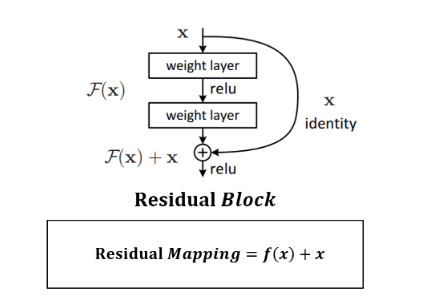

In [32]:
class ResidualBlock(torch.nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.seq = torch.nn.Sequential(
            torch.nn.Linear(in_features, in_features),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(in_features, in_features)
        )
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        fx = self.seq(x)
        x = fx + x
        return self.relu(x)

In [33]:
res_block = ResidualBlock(train_tdm.shape[1])
res_block(batch["x_tdm"]).shape

torch.Size([2, 1024])

In [34]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, in_features, vocab_size, embedding_dim, n_res_layer=8, dropout_prob=0.5):
        super(Net, self).__init__()

        # Residual blocks
        res_layer_list = [ResidualBlock(in_features) for _ in range(n_res_layer)]
        self.seq = nn.Sequential(*res_layer_list)

        # Embedding layer
        self.emb_layer = nn.Embedding(vocab_size, embedding_dim)

        # RNN layer (GRU)
        self.rnn_layer = nn.GRU(embedding_dim, embedding_dim * 2, batch_first=True, bidirectional=True)

        # Dropout layer
        self.dropout = nn.Dropout(dropout_prob)

        # Output layer with batch normalization
        self.fc1 = nn.Linear(in_features + embedding_dim * 4, in_features)  # Intermediate linear layer
        self.bn = nn.BatchNorm1d(in_features)
        self.fc2 = nn.Linear(in_features, 4)  # Final output layer

    def forward(self, x_tdm, x_tokens):
        # Pass through residual blocks
        x_tdm = self.seq(x_tdm)  # batch, features

        # Embedding lookup
        x_tokens = self.emb_layer(x_tokens)  # batch, seq, features

        # RNN layer
        outputs, hn = self.rnn_layer(x_tokens)  # outputs: batch, seq, features; hn: nlayer, batch, features

        # Process RNN output
        x = hn.permute(1, 0, 2).flatten(1)  # batch, nlayer x features

        # Concatenate with TDM features
        x = torch.cat([x_tdm, x], dim=1)  # feature dimension

        # Apply dropout
        x = self.dropout(x)

        # Intermediate fully connected layer with batch normalization
        x = self.fc1(x)
        x = self.bn(x)
        x = torch.relu(x)

        # Final output layer
        x = self.fc2(x)

        return x

In [35]:
batch["x_tdm"].shape, batch["x_tokens"].shape

(torch.Size([2, 1024]), torch.Size([2, 203]))

In [36]:
model = Net( batch["x_tdm"].shape[1], len(vocab), 64 )
model(batch["x_tdm"], batch["x_tokens"])

tensor([[-0.0109, -0.6737, -0.0107,  0.3464],
        [-0.3791,  0.4850, -0.6124, -0.2678]], grad_fn=<AddmmBackward0>)

# 학습 loop 함수

In [37]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    epoch_loss = 0
    model.train() # 학습 모드
    
    for batch in dataloader:
        pred = model( batch["x_tdm"].to(device), batch["x_tokens"].to(device) )
        loss = loss_fn( pred, batch["y"].to(device) )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(dataloader)
    return epoch_loss

# 검증 및 테스트 loop 함수

In [38]:
@torch.no_grad()
def test_loop(dataloader, model, loss_fn, device):
    epoch_loss = 0
    pred_list = []
    act_func = torch.nn.Softmax(dim=1)
    model.eval() # 평가 
    
    for batch in dataloader:
        pred = model( batch["x_tdm"].to(device), batch["x_tokens"].to(device) )
        
        if batch.get("y") is not None:
            loss = loss_fn( pred, batch["y"].to(device) )
            epoch_loss += loss.item()

        pred = act_func(pred) # logit 값을 확률로 변환
        pred = pred.to("cpu").numpy() # cpu 이동후 ndarray 로변환
        pred_list.append(pred)

    epoch_loss /= len(dataloader)
    pred = np.concatenate(pred_list)
    return epoch_loss, pred

# 하이퍼파라미터 정의

In [39]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
n_splits = 5
cv = KFold(n_splits, shuffle=True, random_state=SEED)

batch_size = 32 # 배치 사이즈
loss_fn = torch.nn.CrossEntropyLoss() # 손실 객체
epochs = 100 # 최대 가능한 에폭수

vocab_size = len(vocab) # 단어 사전 크기
embedding_dim = 64 # 임베딩 벡터 크기

# 학습

In [40]:
DATA_PATH

'c:\\study\\04_NLP/data/news/'

In [47]:
is_holdout = False
reset_seeds(SEED) # 재현을 위해 시드고정
best_score_list = []
for i, (tri, vai) in enumerate( cv.split(train_data) ):
    # 학습용 데이터로더 객체
    train_dt = NewsDataset(train_tdm[tri], train_data[tri], target[tri])
    train_dl = torch.utils.data.DataLoader(train_dt, batch_size=batch_size, shuffle=True)

    # 검증용 데이터로더 객체
    valid_dt = NewsDataset(train_tdm[vai], train_data[vai], target[vai])
    valid_dl = torch.utils.data.DataLoader(valid_dt, batch_size=batch_size, shuffle=False)

    # 모델 객체와 옵티마이저 객체 생성
    model = Net(train_tdm.shape[1], vocab_size, embedding_dim).to(device)
    optimizer = torch.optim.Adam( model.parameters() )

    best_score = 0 # 현재 최고 점수
    patience = 0 # 조기 종료 조건을 주기 위한 변수
    for epoch in tqdm(range(epochs)):
        train_loss = train_loop(train_dl, model, loss_fn, optimizer, device)
        valid_loss, pred = test_loop(valid_dl, model, loss_fn, device)

        pred = np.argmax(pred, axis=1) # 다중분류 문제에서 클래스 번호 결정
        score = f1_score(target[vai], pred, average="micro")

        #print(train_loss, valid_loss, score)
        if score > best_score:
            best_score = score # 최고 점수 업데이트
            patience = 0
            torch.save(model.state_dict(), f"{DATA_PATH}/weight/res_model_{i}.pth") # 최고 점수 모델 가중치 저장

        patience += 1
        if patience == 5:
            break

    print(f"{i}번째 폴드 최고 F1-Score micro: {best_score}")
    best_score_list.append(best_score)

    if is_holdout:
        break

  0%|          | 0/100 [00:00<?, ?it/s]

0번째 폴드 최고 F1-Score micro: 0.8282019704433498


  0%|          | 0/100 [00:00<?, ?it/s]

1번째 폴드 최고 F1-Score micro: 0.8282579489476041


  0%|          | 0/100 [00:00<?, ?it/s]

2번째 폴드 최고 F1-Score micro: 0.6877519032691446


  0%|          | 0/100 [00:00<?, ?it/s]

3번째 폴드 최고 F1-Score micro: 0.8415808329601433


  0%|          | 0/100 [00:00<?, ?it/s]

4번째 폴드 최고 F1-Score micro: 0.8328481862964622
